# Analysis

Cross tabulations and generalized linear models using [Samplics](https://github.com/samplics-org/samplics).

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from typing import TypeAlias, Literal
from samplics.categorical import CrossTabulation
from samplics.regression.glm import SurveyGLM
from samplics.estimation import TaylorEstimator

gss: pd.DataFrame = pd.read_csv("data/Theo_extract_3-20-2023.csv")
gss_saf: pd.DataFrame = pd.read_csv("data/Safiya_extract_3-20-2023.csv")

# --------------------------------
# --- Quick clean up (ignore) ----
# --------------------------------
# Any number type (lazy)
Number: TypeAlias = np.number | float | pd.Int64Dtype


def recode_party(partyid: Number) -> Literal["Democrat", "Republican", "Other", pd.NA]:
    """Recode and collapse GSS' `partyid` from numbers to a few strings.

    Parameters
    ----------
    partyid : Number

    Return
    ------
    Literal["Democrat", "Republican", "Other", pd.NA]
    """

    match partyid:
        case _ if pd.isna(partyid):
            return pd.NA
        case 0 | 1 | 2:
            return "Democrat"
        case 4 | 5 | 6:
            return "Republican"
        case 3 | 7:
            return "Other"
        case _:
            return pd.NA


def recode_degree(degree: Number) -> Literal["No degree", "HS or assoc", "College"]:
    """Recode and collapse degree into strings with less categories.

    Parameters
    ----------
    degree : Number

    Return
    ------
    Literal["No degree", "HS or assoc", "College"]
    """

    match degree:
        case _ if pd.isna(degree):
            return pd.NA
        case 0:
            return "No degree"
        case 1 | 2:
            return "HS or assoc"
        case 3 | 4:
            return "College"
        case _:
            return pd.NA


def recode_income(income: Number) -> Literal["<$8K", "$8K to $15K", "$15K+"]:
    """Recode and collapse income into strings with less categories.

    Parameters
    ----------
    income : Number

    Return
    ------
    Literal["<$8K", "$8K to $15K", "$15K+"]
    """

    if pd.isna(income):
        return pd.NA
    elif income in range(1, 8):
        return "<$8K"
    elif income in [8, 9]:
        return "$8K to $15K"
    elif income in [10, 11, 12]:
        return "$15K+"
    else:
        return pd.NA


# R's political party
gss_saf["partyid"] = gss_saf["partyid"].map(recode_party).astype("category")

# Obvious features
# gss_saf["age"] = gss_saf["age"].astype("Int64")
gss_saf["degree"] = (
    gss_saf["degree"].astype("Int64").map(recode_degree).astype("category")
)
gss["degree"] = gss["degree"].astype("Int64").map(recode_degree).astype("category")

sex_map: dict[str, str] = {1: "Male", 2: "Female"}
gss_saf["sex"] = gss_saf["sex"].astype("Int64").map(sex_map).astype("category")
gss["sex"] = gss["sex"].astype("Int64").map(sex_map).astype("category")

gss["income"] = gss["income"].astype("Int64").map(recode_income).astype("category")

# Only recoding the categories used
gss["ethnic"] = (
    gss["ethnic"].astype("Int64").map({1: "Africa", 17: "Mexico"}).astype("category")
)

# Does R speak a language other than English or Spanish?
gss_saf["othlang"] = (
    gss_saf["othlang"].astype("Int64").map({1: "Yes", 2: "No"}).astype("category")
)

# Immigration should be decreased (recoded from letin1a)
gss_saf["decrease_imm"] = (
    gss_saf["decrease_imm"].astype("Int64").map({1: "Yes", 0: "No"}).astype("category")
)

# How important is it for respondent's children to be able to think for themselves?
gss["thnkself"] = (
    gss["thnkself"]
    .astype("Int64")
    .map({1: "Most", 2: "Second", 3: "Third", 4: "Fourth", 5: "Last"})
    .astype("category")
)

# Does the respondent believe in life after death?
gss["postlife"] = gss["postlife"].map({1: "Yes", 2: "No"})


## Cross tabulations

In [106]:
tab_thnk_post = CrossTabulation("proportion")
tab_thnk_post.tabulate(
    vars=gss[["postlife", "thnkself"]],
    samp_weight=gss["wtssall"],
    # There isn't any stratification for the variables used
    # ...or there's only one PSU. Something like that.
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)

print(tab_thnk_post)



Cross-tabulation of postlife and thnkself
 Number of strata: 1
 Number of PSUs: 2
 Number of observations: 8167
 Degrees of freedom: 1.00

 postlife thnkself  proportion  stderror  lower_ci  upper_ci
      No   Fourth    0.030365  0.002184  0.012053  0.074401
      No     Last    0.010181  0.000394  0.006219  0.016625
      No     Most    0.092465  0.001289  0.077340  0.110196
      No   Second    0.034407  0.000216  0.031767  0.037258
      No    Third    0.031475  0.000818  0.022583  0.043711
     Yes   Fourth    0.140978  0.009139  0.059188  0.299778
     Yes     Last    0.037669  0.000800  0.028721  0.049265
     Yes     Most    0.326757  0.003157  0.287977  0.368060
     Yes   Second    0.157055  0.000825  0.146851  0.167829
     Yes    Third    0.138646  0.002275  0.112183  0.170156

Pearson (with Rao-Scott adjustment):
	Unadjusted - chi2(4): 19.9821 with p-value of 0.0005
	Adjusted - F(1.00, 1.00): 6.1194  with p-value of 0.2446

  Likelihood ratio (with Rao-Scott adjustment):


## Generalized linear regression

In [108]:
# Explicitly drop NAs because remove_nan doesn't do it for some reason
gss_saf = gss_saf.dropna()

# Variable names for features
X_features = ["year", "age", "degree", "sex", "partyid", "coninc"]
X_imm_dummies = pd.get_dummies(gss_saf[X_features], drop_first=True)
X_imm_dummies = sm.add_constant(X_imm_dummies)

# Target feature
y_feature = pd.get_dummies(gss_saf["decrease_imm"])

# I wish samplics wasn't incomplete.
# Fit the model
glm_imm = SurveyGLM()
glm_imm.estimate(
    y=y_feature,
    x=X_imm_dummies,
    samp_weight=gss_saf["wtssnrps"],
    # stratum=saf_gss["vstrat"],
    psu=gss_saf["vpsu"],
    remove_nan=True,
)

results_imm = pd.DataFrame(
    [glm.beta, *glm.cov_beta], columns=X_features, index=["coef", *X_features]
).T

print(results_imm)


ValueError: operands could not be broadcast together with shapes (9045,2) (9045,) 

In [109]:
# Binomial regression
glm_imm = sm.GLM(
    y_feature,
    X_imm_dummies,
    family=sm.families.Binomial(),
    var_weights=gss_saf["wtssnrps"],
    missing="drop",
)

results_imm = glm_imm.fit()
print(results_imm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          ['No', 'Yes']   No. Observations:                 9045
Model:                            GLM   Df Residuals:                     9036
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5462.6
Date:                Sun, 26 Mar 2023   Deviance:                       10925.
Time:                        03:37:56   Pearson chi2:                 8.77e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1048
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -160.0024     12

# Side by side plots

The following plots use Samplics to ensure proper weighting by calculating a cross tab of the variables.

Samplics throws a ["lonely PSU"](https://r-survey.r-forge.r-project.org/survey/exmample-lonely.html) exception because there is only only PSU per the strata (or something). I commented out the `stratum` parameter to squelch the error.

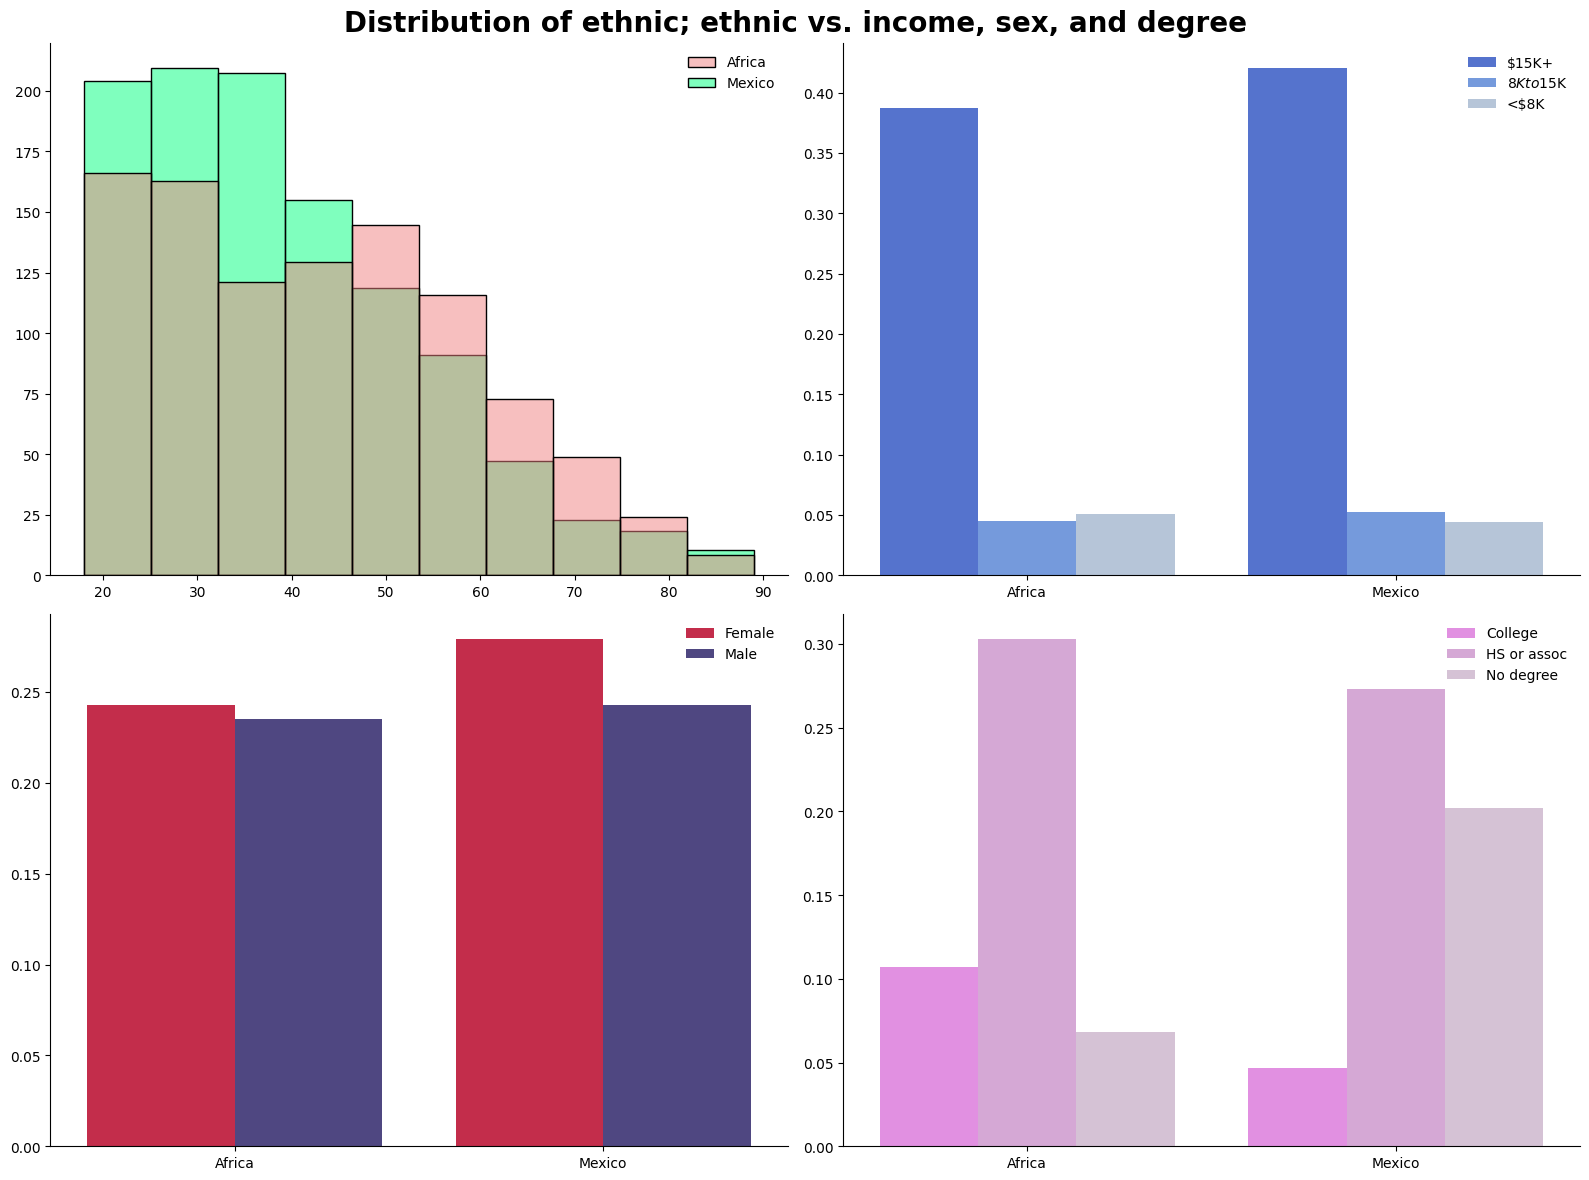

In [127]:
# Color maps
# Pan-African colors are red, green, and black
ethnicity = {"Africa": "lightcoral", "Mexico": "springgreen"}

gender = {"Female": "crimson", "Male": "darkslateblue"}

income = {
    "<$8K": "lightsteelblue",
    "$8K to $15K": "cornflowerblue",
    "$15K+": "royalblue",
}

degree = {
    "No degree": "thistle",
    "HS or assoc": "plum",
    "College": "violet",
}

# Two rows and two columns
comp_fig, comp_axes = plt.subplots(2, 2, figsize=(16, 12))

# The following code can be greatly simplified with a for loop, but it may
# be too confusing to follow for students with a shaky grasp on Python.
# I'll just write it out verbosely for now.

# Plot the age histogram on the first subplot
sns.histplot(
    gss,
    x="age",
    hue="ethnic",
    weights="wtssall",
    palette=ethnicity,
    bins=10,
    ax=comp_axes[0][0],
)

# Cross tabulate ethnic/income
ethn_inc = CrossTabulation("proportion")
ethn_inc.tabulate(
    vars=gss[["ethnic", "income"]],
    samp_weight=gss["wtssall"],
    # Lonely PSU
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)
ethn_inc = ethn_inc.to_dataframe()

# Plot cross tab on the second subplot
_ = sns.barplot(
    x=ethn_inc.ethnic,
    y=ethn_inc.proportion,
    hue=ethn_inc.income,
    palette=income,
    ax=comp_axes[0][1],
)

# Cross tabulate ethnic/sex
ethn_sex = CrossTabulation("proportion")
ethn_sex.tabulate(
    vars=gss[["ethnic", "sex"]],
    samp_weight=gss["wtssall"],
    # Lonely PSU
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)
ethn_sex = ethn_sex.to_dataframe()

# Plot ethnic/sex cross tab
_ = sns.barplot(
    x=ethn_sex.ethnic,
    y=ethn_sex.proportion,
    hue=ethn_sex.sex,
    palette=gender,
    ax=comp_axes[1][0],
)

# Cross tabulate ethnic/degree
ethn_degr = CrossTabulation("proportion")
ethn_degr.tabulate(
    vars=gss[["ethnic", "degree"]],
    samp_weight=gss["wtssall"],
    # Lonely PSU
    # stratum=gss["vstrat"],
    psu=gss["vpsu"],
    remove_nan=True,
)
ethn_degr = ethn_degr.to_dataframe()

# Plot ethnic/degree cross tab
_ = sns.barplot(
    x=ethn_degr.ethnic,
    y=ethn_degr.proportion,
    hue=ethn_degr.degree,
    palette=degree,
    ax=comp_axes[1][1],
)

# Titles et cetera
for ax in comp_axes.flat:
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    # Remove legend title
    legend = ax.get_legend()
    legend.set_title(None)
    legend.draw_frame(False)

    # Remove plot spines
    sns.despine(comp_fig, ax)


_ = comp_fig.suptitle(
    "Distribution of ethnic; ethnic vs. income, sex, and degree", fontsize=20, fontweight="bold"
)

comp_fig.set_tight_layout(True)
